In [9]:
import numpy as np
from numpy import array, sin, cos, dot, random, zeros, ones, exp
from scipy.optimize import minimize, root
from scipy.linalg import solve, norm
from scipy.integrate import simps
from scipy.interpolate import lagrange
from math import pi
import sys
import matplotlib.pyplot as plt
from matplotlib import animation,rc
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt

## Mechanical System

In [137]:
#change here
#------------
Duration = 2;
FPS = 100;
starting_point = array([0.05+pi,0,0,0])
#-----------
dt = 1./FPS
N = int(Duration*FPS);
friction = 2

def acrobot_gradient(x, u):
    g = 9.8
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) - 2*g*sin(x[0]) - g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) - g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    B = np.concatenate([[0,0],solve(M,array([0,1]))])
    xd = a + B*u
    return xd
    
def acrobot_next_step(x,u):
    
    xd = acrobot_gradient(x,u)
    new_x = x + xd*dt
    #limit angle range to [0, 2pi]
    new_x[0]=new_x[0]%(2*pi)
    new_x[1]=new_x[1]%(2*pi)
    #avoid acceleration overflow
    return np.clip(new_x,-100,100)
#r=k=1
#cost_function = lambda x,u,r,k : r/2*u**2 + 1 - exp(k*cos(x[0]) + k*cos(x[1])-2*k)
#cost_function = lambda x,u : u**2 + dot(x,x)

#define partial derivation functions
def numerical_dfdxT(x,u):
    delta = 0.0001
    out = zeros([4,4])
    for i in range(4):
        delta_v = zeros(4)
        delta_v[i] = delta
        #print(x+delta_v)
        out[i] = ((acrobot_gradient(x+delta_v,u)-acrobot_gradient(x-delta_v,u))*dt+2*delta_v)/2/delta
    return out

def dfdxT(x,u):
    g = 9.8
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],
               [1+cos(x[1]),    1]
              ])
    C = array([[-2*sin(x[1])*x[3], -sin(x[1])*x[3]],
               [sin(x[1])*x[2],    0]
              ])
    dGdq = array([[g*(2*cos(x[0])+cos(x[0]+x[1])),g*cos(x[0]+x[1])],
                  [g*cos(x[0]+x[1]),              g*cos(x[0]+x[1])]
                 ])
    bottom_left = - solve(M,dGdq)
    bottom_right = - solve(M,C+np.identity(2)*friction)
    xd= array([[0,0,1,0],
                  [0,0,0,1],
                  [bottom_left[0,0],bottom_left[0,1],bottom_right[0,0],bottom_right[0,1]],
                  [bottom_left[1,0],bottom_left[1,1],bottom_right[1,0],bottom_right[1,1]]
                 ])
    x = xd*dt+np.identity(4)
    return x.T

def dfdu(x,u):
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    B = np.concatenate([[0,0],solve(M,array([0,1]))])
    return dt*B

def dgdx(x,u):
    k=1
    out = zeros(4)
    x1= x[0]
    x2= x[1]
    out[0] = -exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x1)
    out[1] = exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x2)
    return out
dgdu = lambda x,u : 0.2*u

## Linearized Mechanical System

In [83]:
#TODO
def acrobot_gradient_linearized_around_0(x, u):
    friction = 2
    g = 9.8
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) + g*sin(x[0]) + g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) + g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    B = np.concatenate([[0,0],solve(M,array([0,1]))])
    xd = a + B*u
    return xd

## Lagrangian Bruteforce

In [84]:
#brute force method, not converging

def lagrangian(input_array):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
    x = np.concatenate([starting_point,input_array[:(N-1)*4]])
    u = input_array[(N-1)*4:(N-1)*4+N]
    lam = input_array[(N-1)*4+N:-1]

    L=0
    for i in range(N-1):
        #current x
        xx = x[i*4:(i+1)*4]
        #next x
        xx_p1 = x[(i+1)*4:(i+2)*4]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_motion(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i])
        lagragian_term = lam[i]*(delta[0:1]%(2*pi))
        L+=cost+lagragian_term
    return L
def lagrangian_train():
    init = np.ones(N*4+N+N)
    out = minimize(lagrangian,init)

## Lagrangian multiplier derivation

In [142]:
def grad_lagrangian_trick(u):
    # u is a vector of u0 to uN-1
    n=len(u)
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    dldu = zeros(n)
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i])+dot(dfdxT(x[i],u[i]),lam[i])
    
    for i in range(n):
        dldu[i]=dgdu(x[i],u[i])+dot(lam[i],dfdu(x[i],u[i]))
    
    return dldu

def lagrangian_train(dt,N):
    u = zeros(N)#random.normal(0,size=N)
    out = root(grad_lagrangian_trick,u) 
    return (out,out.x)

## Chebyshev

In [86]:
def interpolate_fit(x, coef):
    f = lambda x : sum([pow(x, y)*coef[y] for y in range(len(coef))])
    vfunc = np.vectorize(f)
    return vfunc(x)

def chebyshev_gradient(ts,order,cheby_t,cheby_u):
    def interpolate_grad_fit(x, cheby_t, cheby_u):
        # fit gradient of model relate to cheby u
        # dL(t)dwj = lj(t) = (x-x0)/(xj-x0)....x-xk)/(xj-xk)
        f = lambda x : array(
            [
                np.prod([
                    (x-xi)/(xj-xi) 
                    for xi in cheby_t if xi!=xj
                ]) 
                for xj in cheby_t
            ]
        )
        return array([f(xx) for xx in x])
    #calculate u according to current chebyshev
    poly = np.flipud(lagrange(cheby_t,cheby_u))
    u = interpolate_fit(ts, poly)
    # calculate dLdw
    dldu = grad_lagrangian_trick(u)
    dudw = interpolate_grad_fit(ts, cheby_t, cheby_u)
    return array([simps(dudw[:,i]*dldu,ts) for i in range(order)])

def chebyshev_train(dt,N,order):
    chebyshev = lambda n: array([cos((2*j-1)*pi/(2*n)) for j in range(1,n+1)])
    Duration = N*dt
    ts = np.arange(N)*dt
    cheby_t = (chebyshev(order)+1)*Duration/2
    cheby_u = random.normal(0,size=order)
    
    local_chebyshev_gradient = lambda cheby_u: chebyshev_gradient(ts,order,cheby_t,cheby_u)
    out = root(local_chebyshev_gradient,cheby_u)
    
    #get final u array
    poly = np.flipud(lagrange(cheby_t,out.x))
    u = interpolate_fit(ts, poly)
    return (out,u)

## Fit

In [147]:
#out = chebyshev_train(dt,N,15) 
out = lagrangian_train(dt,N)
u = out[1]


## Simulation

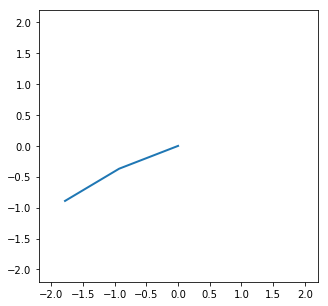

In [148]:
#u = zeros(N)
def simulation(x,u):
    x = np.zeros((N, 4))
    x[0] = starting_point
    for i in range(N-1):
        x[i+1] = acrobot_next_step(x[i], u[i])

    return x

x = np.zeros((N, 4))
x[0] = starting_point
x = simulation(x,u)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(k):
    x1 = cos(x[k,0]-pi/2);
    y1 = sin(x[k,0]-pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]-pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]-pi/2);
    
    xs = [0, x1, x2]
    ys = [0, y1, y2]
    line.set_data(xs, ys)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)
HTML(anim.to_html5_video())

## Plot

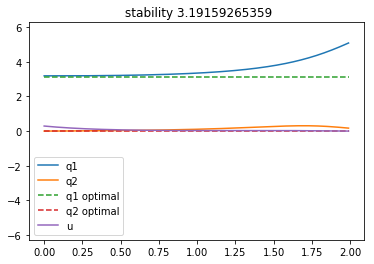

In [149]:
ts = np.arange(N)*dt
plt.plot(ts,x[:,0],label="q1")
plt.plot(ts,x[:,1],label="q2")
plt.plot(ts,ones(N)*pi,"--",label="q1 optimal")
plt.plot(ts,zeros(N),"--",label="q2 optimal")
plt.plot(ts,u,label="u")
plt.legend()
plt.ylim([-2*pi,2*pi])
plt.title(" stability "+ str(starting_point[0]))
plt.show()

In [146]:
out[0]

    fjac: array([[ -3.07060713e-02,   6.12832739e-01,   2.02088065e-01,
          6.29887637e-01,   1.71270943e-01,   8.53814063e-02,
          6.01084827e-02,   5.29317158e-02,   8.22843387e-02,
          1.17073967e-01,   1.62039673e-01,   1.90218659e-01,
          1.90775878e-01,   1.45755994e-01,   4.79517358e-02],
       [  6.24675673e-01,   1.73673342e-01,   1.17462588e-01,
         -3.22681928e-01,  -2.20386954e-01,   4.50509172e-01,
         -1.79848044e-01,   2.37345344e-01,  -9.81859810e-02,
          2.08435260e-01,   7.78251438e-04,   2.12111164e-01,
          6.32161991e-02,   1.38446420e-01,   1.57650780e-02],
       [  6.01834055e-01,  -4.43354343e-01,  -1.98637402e-02,
          6.05534486e-01,   4.94640243e-02,  -1.31642226e-01,
         -1.12870248e-01,  -2.97327525e-02,  -5.60775814e-02,
         -5.50705334e-02,  -9.01681425e-02,  -9.77799407e-02,
         -1.01787094e-01,  -7.69181548e-02,  -2.49065205e-02],
       [ -1.98502129e-01,  -1.59008742e-01,  -7.88295963e

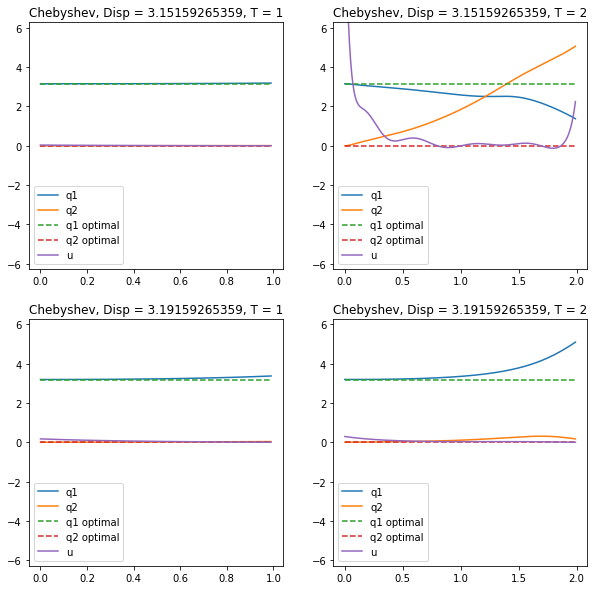

In [144]:
# multiple plot
conditions = [array([0.01+pi,0,0,0]),array([0.05+pi,0,0,0])]
durations = [1,2]
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i in range(len(conditions)):
    for d in range(len(durations)):
        Duration = durations[d]
        starting_point = conditions[i]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=chebyshev_train(dt,N,13)[1]
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(x,u)
        
        axes[i, d].set_ylim([-2*pi,2*pi])
        axes[i, d].plot(ts,x[:,0],label="q1")
        axes[i, d].plot(ts,x[:,1],label="q2")
        axes[i, d].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i, d].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i, d].plot(ts,u,label="u")
        axes[i, d].legend()
        axes[i, d].set_title("Chebyshev, Disp = "+str(starting_point[0])+", T = "+str(Duration))

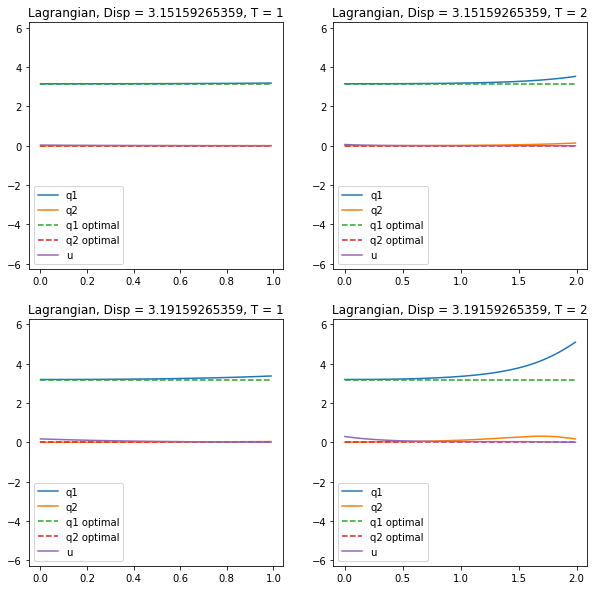

In [145]:
# multiple plot
conditions = [array([0.01+pi,0,0,0]),array([0.05+pi,0,0,0])]
durations = [1,2]
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i in range(len(conditions)):
    for d in range(len(durations)):
        Duration = durations[d]
        starting_point = conditions[i]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=lagrangian_train(dt,N)[1]
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(x,u)
        
        axes[i, d].set_ylim([-2*pi,2*pi])
        axes[i, d].plot(ts,x[:,0],label="q1")
        axes[i, d].plot(ts,x[:,1],label="q2")
        axes[i, d].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i, d].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i, d].plot(ts,u,label="u")
        axes[i, d].legend()
        axes[i, d].set_title("Lagrangian, Disp = "+str(starting_point[0])+", T = "+str(Duration))

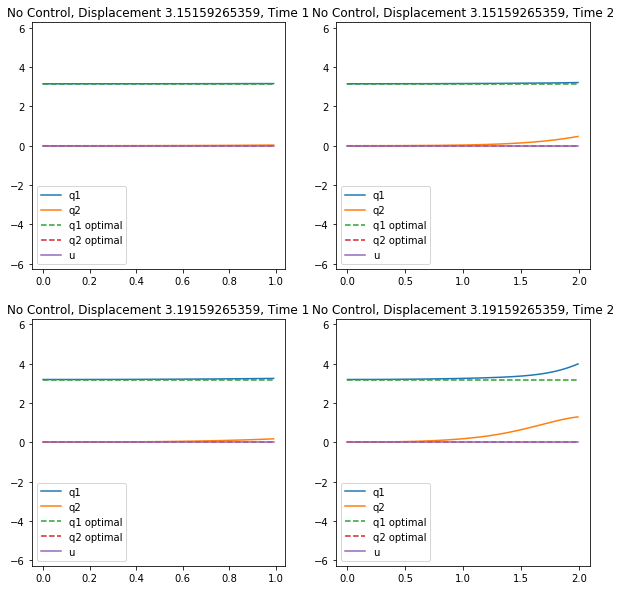

In [53]:
# multiple plot
conditions = [array([0.01+pi,0,0,0]),array([0.05+pi,0,0,0])]
durations = [1,2]
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i in range(len(conditions)):
    for d in range(len(durations)):
        Duration = durations[d]
        starting_point = conditions[i]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=np.zeros(N)
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(x,u)
        
        axes[i, d].set_ylim([-2*pi,2*pi])
        axes[i, d].plot(ts,x[:,0],label="q1")
        axes[i, d].plot(ts,x[:,1],label="q2")
        axes[i, d].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i, d].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i, d].plot(ts,u,label="u")
        axes[i, d].legend()
        axes[i, d].set_title("No Control, Displacement "+str(starting_point[0])+", Time "+str(Duration))


# test codes, will delete in the end


First, we add frictions to the system:

$Bu = B\hat{u}-f\dot{q}$

So that:

$H(q)\ddot{q}+C(q,\dot{q})\dot{q}+G(q)=B\hat{u}-f\dot{q}$

Afterward, $\ddot{q}$ can be calculated as:

$\ddot{q}=H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)+B\hat{u}-f\dot{q}]$

$\ddot{q}=H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)-f\dot{q}]+H(q)^{-1}B\hat{u}$

Thus,

$\dot{x} = \begin{bmatrix} \dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2} \end{bmatrix} = \begin{bmatrix} \dot{q_1} \\ \dot{q_2} \\ H(q)^{-1}[-C(q,\dot{q})\dot{q}-G(q)-f\dot{q}] \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ H(q)^{-1}B \end{bmatrix}\hat{u}$

After setting all constants to 1, the system can be simplified so that:

$H(q) = \begin{bmatrix} 3+2cos(q_2) & 1+cos(q_2) \\ 1+cos(q_2) & 1 \end{bmatrix}$

$G(q)=\begin{bmatrix} gsin(q_1)+g(sin(q_1)+sin(q_1+q_2)) \\ gsin(q_1+q_2) \end{bmatrix}$

$C(q,\dot{q})=\begin{bmatrix} -2sin(q_2)\dot{q_2} & -sin(q_2)\dot{q_2} \\ sin(q_2)\dot{q_1} & 0 \end{bmatrix}$

Thus:

$-C(q,\dot{q})\dot{q}-G(q) = \begin{bmatrix} 2sin(q_2)\dot{q_1}\dot{q_2}+sin(q_2)\dot{q_2}^2 \\ -sin(q_2)\dot{q_1}^2 \end{bmatrix}-\begin{bmatrix} gsin(q_1)+g(sin(q_1)+sin(q_1+q_2)) \\ gsin(q_1+q_2) \end{bmatrix} =  \begin{bmatrix} \dot{q_2}(2\dot{q_1}+\dot{q_2})sin(q_2)-2g sin(q_1)-gsin(q_1+q_2) \\ -\dot{q_1}^2sin(q_2)-gsin(q_1+q_2) \end{bmatrix}$

## Chebyshev

Theoretically, u should be very similar in adjacent time steps. It might be a waste to optimize all of them individually, considering the large number of u needed. To reduce the dimention of problem, we tried to model u as a polynomial through chebyshev points.

The basic idea is to fit a curve $g(t,w)$ that represents the pattern of torque u at different time t under parameter w. To minimize interpolation error, roots of Chebyshev Polynomial are used as sampling points. Chebyshev points are be calculated through equation below:

$xj = cos((2j − 1)\pi/2n), j = 1, . . . , n$

Then, instead of optimizing all u together, we only need to optimize w, the u values at selected chebyshev points.

The gradient can be calculated through:

$\frac{\partial L}{\partial w} = \int_0^T g_w(t,w)^T\frac{\partial L}{\partial u(t)}dt$

Where $\frac{\partial L}{\partial u(t)}$ can be found through Lagrangian Multiplier Derivation equation above.

To calculate $g_w(t,w)$, we model g(t,w) as Lagrangian Polynomial with following equations:

$l_j(x)=\frac{x-x_0}{x_j-x_0}...\frac{x-x_{j-1}}{x_j-x_{j-1}}\frac{x-x_{j+1}}{x_j-x_{j+1}}...\frac{x-x_k}{x_j-x_k}$

$g(x_i)=\sum_{j=0}^ky_jl_j(x_i)$

Where $x_0...x_k$ are roots of Chebyshev polynomials and $y_0...y_k$ are elements of w.

Doing Partial Derivation to equation above yeilds:

$\frac{\partial g(x_i)}{\partial w_j} = l_j(x_i)$

Thus:

$\frac{\partial L}{\partial w} = \int_0^T \begin{bmatrix} l_0(x) \\  ... \\ l_k(x) \end{bmatrix}\frac{\partial L}{\partial u(t)}dt$

In [181]:
out[0]

    fjac: array([[-0.23082451, -0.21468929, -0.20971394, ..., -0.00232775,
        -0.00117227,  0.        ],
       [ 0.66458109, -0.7340041 , -0.00991497, ...,  0.00643192,
         0.00341761,  0.        ],
       [ 0.3969111 ,  0.38477732, -0.82982931, ...,  0.00388551,
         0.00206182,  0.        ],
       ..., 
       [-0.01541661, -0.02195501, -0.02112281, ..., -0.99149894,
         0.00782878,  0.        ],
       [-0.00856481, -0.01217243, -0.01170401, ...,  0.00150753,
        -0.99742922,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        , -1.        ]])
     fun: array([  1.31998323e-09,   1.28992106e-09,   1.26144384e-09,
         1.23192342e-09,   1.20422569e-09,   1.17725280e-09,
         1.15035595e-09,   1.12545492e-09,   1.10093639e-09,
         1.07579102e-09,   1.04857248e-09,   1.01935567e-09,
         9.88180912e-10,   9.59519880e-10,   9.36973554e-10,
         9.21794335e-10,   9.13865095e-10,   9.09319328e-10,


In [124]:
np.identity(4)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])